### Importing library

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten
from keras.callbacks import EarlyStopping

In [3]:
from matplotlib import rcParams
rcParams["font.weight"] = "bold"
rcParams["axes.labelweight"] = "bold"

rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelweight'] = 'bold'
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'STIXGeneral:italic'
rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'

2. Menyiapkan fungsi untuk mengkonversi array kedalam matriks
yang input-output yang diinginkan

In [4]:
def split_data(data, n_input, n_out): 
    in_start = 0
    X, y = list(), list()   
    for _ in range(len(data)):
        
        in_end = in_start + n_input
        out_end = in_end + n_out
        
        if out_end < len(data):
            X.append(data[in_start:in_end])
            y.append(data[in_end:out_end])
        
        in_start += n_out
    X, y = np.array(X), np.array(y)
    return X.reshape(X.shape[0], X.shape[1]), y.reshape(y.shape[0], y.shape[1])

In [5]:
np.random.seed(100) # Kode bilangan random

3. Load dataset

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [7]:
!ls "/content/gdrive/My Drive/Tugas Akhir"

 1111_hs_ds1_compressed_filter.csv
 1111_hs_ds1ds2_compressed_filter.csv
 1111_hs_ds2_compressed_filter.csv
 1111_untuk_plot_ANN.csv
 1111_untuk_plot.csv
 angin_baron_mei_sep.csv
 angin_juli_sep.csv
 angin_juli_sep_fix.csv
 baron_1h_cleaning.csv
 baron_1h.csv
 baron_1h_pp.csv
 baron_1h_pp_FIX.csv
 baron_6h.csv
 bl_model_baru5.h5
 bl_model_baru6.h5
 bl_model_baru_baru2.h5
 bl_model_baru_baru.h5
 bl_model_baru.h5
 bl_model.h5
'bl_plot_data_test2 - Sheet1 - bl_plot_data_test - Sheet1.csv'
'bl_plot_data_test2 - Sheet1.gsheet'
'bl_plot_data_test - Sheet1.csv'
'bl_plot_data_test - Sheet1.gsheet'
 bl_pp_nested.csv
 bl_pp_nested.gsheet
 bl_pp_nested_hs.csv
'[bl]_preprocessing.txt'
 bl_raw.csv
 bl_raw_nested.csv
'[bl]_testPredict.txt'
'[bl]_trainPredict.txt'
'bl_untuk_plot_baru - bl_untuk_plot (1).gsheet'
'bl_untuk_plot_baru - bl_untuk_plot.csv'
'bl_untuk_plot_baru - bl_untuk_plot.gsheet'
 bl_untuk_plot_baru.gsheet
'bl_untuk_plot_baru_train_val -  bl_untuk_plot.csv'
 bl_untuk_plot_baru_train_va

In [8]:
dataset = pd.read_csv('gdrive/My Drive/Tugas Akhir/galway2th.csv', names=['hs'])

nan = np.nan
dataset = dataset.interpolate(methode='cubic') # INTERPOLATING DATA

hs = dataset

### Standardize the data

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_hs = scaler.fit_transform(hs)

Text(0, 0.5, 'Hs [m]')

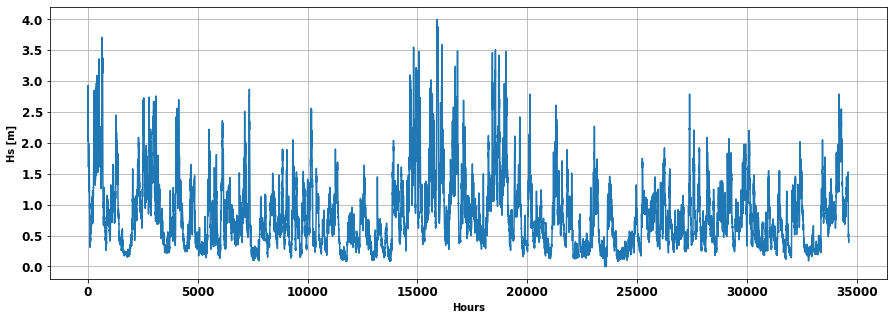

In [10]:
plt.figure(figsize=(15,5))
plt.plot(hs)
plt.grid()
plt.xlabel('Hours')
plt.ylabel('Hs [m]')


In [11]:
n_train = int(len(scaled_hs)*0.70)
n_test = len(scaled_hs) - n_train
train, test = scaled_hs[0:n_train, :], scaled_hs[n_train:len(scaled_hs),:]

### Building input data

In [12]:
look_back = 12 # number of input data in previous time step
n_out = 1
trainX, trainY = split_data(train, look_back, n_out)
testX, testY = split_data(test, look_back, n_out)

In [13]:
pd.DataFrame(trainX).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.5075,0.5225,0.5800,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125
1,0.5225,0.5800,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125
2,0.5800,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125,0.5875
3,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125,0.5875,0.5625
4,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125,0.5875,0.5625,0.5575


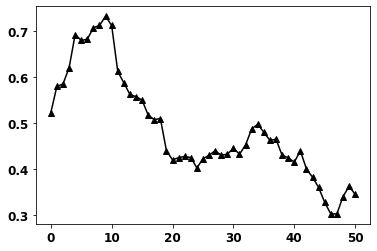

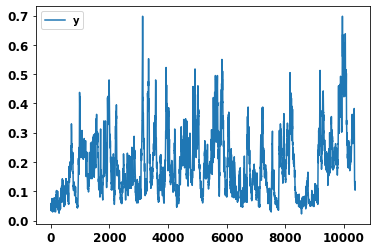

In [14]:
plt.figure(1)
plt.plot(train[1:52], marker='^', color='black', label='X')
plt.figure(2)
plt.plot(testY, label='y')
plt.legend()
plt.show()

In [15]:
trainX.shape[0]

24230

### Reshaping data (1D - 3D)
In LSTM, the input data should be 3D (sample, time step, feature)
LSTM mengharuskan inputnya berbentuk 3D (samples, time step, feature).

In [16]:
trainX_r = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1)) # Baris - timestep - kolom
trainY_r = np.reshape(trainY, (trainY.shape[0], trainY.shape[1], 1))
testX_r = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
testY_r = np.reshape(testY, (testY.shape[0], testY.shape[1], 1))

print(trainX_r.shape, trainY.shape)

(24230, 12, 1) (24230, 1)


### LSTM Model

In [ ]:
from keras.layers import TimeDistributed, RepeatVector

batch_size=1
model = Sequential()
model.add(Bidirectional(LSTM(40, activation='tanh', input_shape=(trainX.shape[1], 1),
                             batch_input_shape=(batch_size, look_back, 1))))
model.add(RepeatVector(trainY.shape[1]))
model.add(Bidirectional(LSTM(40, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(40, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(40, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(40, activation='tanh', dropout=0.3, recurrent_regularizer='l2', return_sequences=True)))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='nadam', loss='mse')


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, 
                           patience=10, verbose=0, mode='auto', 
                           baseline=None, restore_best_weights=False)]

history = model.fit(trainX_r, trainY_r, 
                    validation_split=0.1, 
                    epochs = 20, batch_size=10, 
                    verbose=1, 
                    callbacks = callbacks)


Epoch 1/20


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-2a3af44ad377>", line 9, in <module>
    callbacks = callbacks)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1158, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 933, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 764, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 3050, in _get_concrete_function

KeyboardInterrupt: ignored

In [17]:
#Load model
from keras.models import load_model
model = load_model('gdrive/My Drive/Tugas Akhir/GL_model_kgml.h5')

In [18]:
trainPredict = model.predict(trainX_r)
testPredict = model.predict(testX_r)

In [19]:
#trainPredict = scaler.inverse_transform(trainPredict.reshape(trainPredict.shape[0], trainPredict.shape[1]))
#trainY = scaler.inverse_transform(trainY.reshape(trainY.shape[0], trainY.shape[1]))
#testPredict = scaler.inverse_transform(testPredict.reshape(testPredict.shape[0], testPredict.shape[1]))
#testY = scaler.inverse_transform(testY.reshape(testY.shape[0], testY.shape[1]))

### Evaluate the model

In [20]:
trainY_r_inv = scaler.inverse_transform(trainY_r.reshape(-1,1))
testY_r_inv = scaler.inverse_transform(testY_r.reshape(-1,1))

trainPredict_inv = scaler.inverse_transform(trainPredict.reshape(-1,1))
testPredict_inv = scaler.inverse_transform(testPredict.reshape(-1,1))

rmse_train = math.sqrt(mean_squared_error(trainY_r_inv.flatten(), trainPredict_inv.flatten()))
rmse_test = math.sqrt(mean_squared_error(testY_r_inv.flatten(), testPredict_inv.flatten()))
bias_train = np.mean(trainPredict_inv.flatten() - trainY_r_inv.flatten())
bias_test = np.mean(testPredict_inv.flatten() - testY_r_inv.flatten())

print('RMSE Train data : %.2f cm' %(rmse_train*100))
print('RMSE Test data : %.2f cm' %(rmse_test*100))
print('Bias Train :', bias_train)
print('Bias Test : ', bias_test)

RMSE Train data : 6.69 cm
RMSE Test data : 5.03 cm
Bias Train : 0.0038890421768136116
Bias Test :  0.007835618127263057


In [21]:
trainY.shape

(24230, 1)

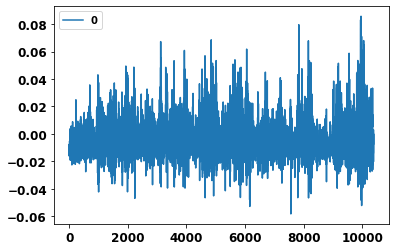

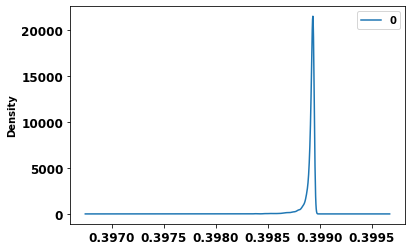

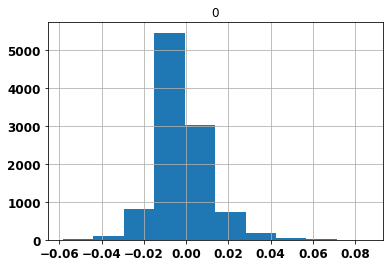

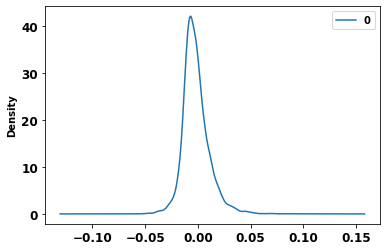

In [22]:
from scipy.stats import norm

residual_test = pd.DataFrame(testY.flatten() - testPredict.flatten())
residual_test.plot()
m, s = norm.fit(residual_test)
#dist_norm = pd.DataFrame(norm.pdf(residual_test, m, s))
dist_norm = pd.DataFrame(norm.pdf(residual_test))
dist_norm.plot(kind='kde')
plt.show()
residual_test.hist()
residual_test.plot(kind='kde')
plt.show()

In [23]:
# Plot training & validation loss values
'''plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss (MSE (m))')
plt.xlabel('Epoch (iterasi)')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
'''

"plt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('Model loss')\nplt.ylabel('Loss (MSE (m))')\nplt.xlabel('Epoch (iterasi)')\nplt.legend(['Train', 'Validation'], loc='upper right')\nplt.show()\n"

### Visualize the result

In [24]:
# data for plot
trainPredictPlot = np.empty_like(hs) # membuat matriks kosong dgn dimensi sama seperti raw data
trainPredictPlot[:,:] = np.nan # mengisi matriks tsb dgn NaN
trainPredictPlot[look_back:len(trainPredict.flatten())+look_back, :] = np.array([trainPredict.flatten()]).T # mengsinkronkan skala dgn hasil prediksi

testPredictPlot = np.empty_like(hs)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict.flatten())+(look_back*2)+1 : len(hs)-1, :] = np.array([testPredict.flatten()]).T


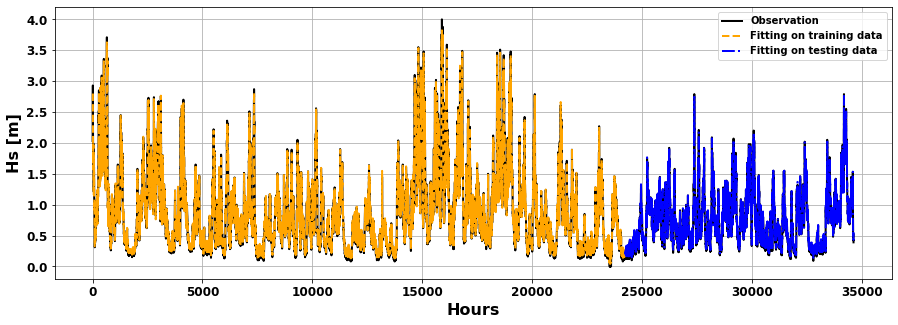

In [25]:
trainPredictPlot_inv = scaler.inverse_transform(trainPredictPlot.reshape(-1,1))
testPredictPlot_inv = scaler.inverse_transform(testPredictPlot.reshape(-1,1))

plt.figure(figsize=(15,5))
plt.plot(hs, linestyle = '-', color='black', marker='', linewidth =2, label='Observation')
plt.plot(trainPredictPlot_inv, linestyle = '--', marker='', color='orange', linewidth=2, label='Fitting on training data')
plt.plot(testPredictPlot_inv, linestyle = '-.', marker='', color='blue', linewidth=2, label='Fitting on testing data')

plt.xlabel('Hours', fontsize=16)
plt.ylabel('Hs [m]', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

In [53]:
def predict_hs(input_pred, look_back, n_out):
  
  last_lb = input_pred
  pred_out = list()

  ni = 0
  for i in range(0, int(48/n_out)): # 48 hours multi-step prediction
    last_lb_r = last_lb.reshape(1, look_back, 1) # (n_example, n_timestep, n_feature)
    pred = model.predict(last_lb_r)
    last_lb = np.append(last_lb, pred)
    last_lb = np.array([last_lb])
    ni = n_out
    last_lb = last_lb[:, ni:]
    pred.tolist()
    pred_out.extend(pred)

  pred_out = np.array(pred_out)
  pred_out = pred_out.reshape(pred_out.shape[0],pred_out.shape[1])
  pred_out = pred_out.flatten()

  return pred_out


In [27]:
def plot_predict(input_pred, pred_out, obs_data):

  f = np.linspace(1,72,72)

  onx = np.array([pred_out]).shape[1]
  obs = obs_data.flatten()

  plt.figure(figsize=(15,6))
  plt.plot(f[:onx], pred_out, linestyle='-', marker='o', color='blue', label='Predicted') #o
  plt.plot(f[:onx], obs, linestyle='-', marker='^', color='black', label='Observation') #^
  plt.xlabel('Hours',fontweight='bold', fontsize=16)
  plt.ylabel('$\it{Hs}$ (m)', fontweight='bold', fontsize=16)
  #plt.ylim(0, 2)
  plt.legend()
  plt.grid()

Sampel Prediction on Testing Data



findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


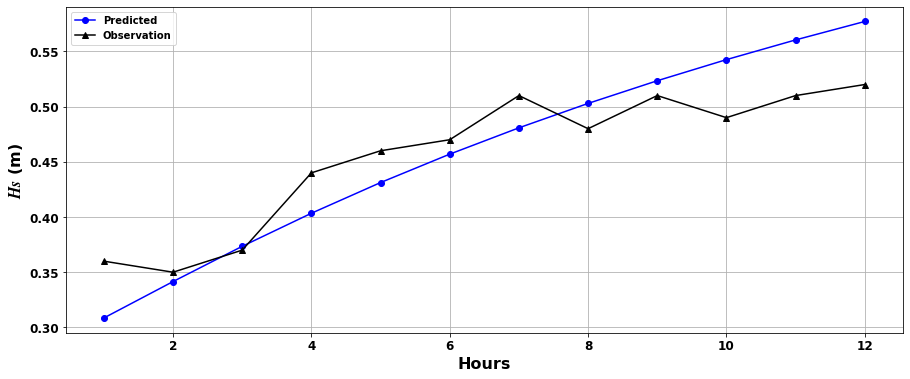

In [28]:
print('Sampel Prediction on Testing Data\n')
sam = 1772
look_back = testX.shape[1]
pred_sam = predict_hs(testX[sam], look_back, n_out)

# rescaling data into original
testY_inv = scaler.inverse_transform(testY)
obs_sam_inv = testY_inv[sam:sam+12]
pred_sam_inv = scaler.inverse_transform(np.array(pred_sam).reshape(-1,1))
plot_predict(testX[sam], pred_sam_inv, obs_sam_inv) 

In [29]:
obs_sam = testY_inv[sam:sam+12].flatten() 
rmse_pred = math.sqrt(np.mean((pred_sam_inv-obs_sam)**2))
print('RMSE sampel:', rmse_pred*100,'cm')

from scipy.stats import pearsonr

korelasi = pearsonr(pred_sam, obs_sam)
print('Korelasi, p-value:', korelasi)
print('Bias:',np.mean(pred_sam_inv-obs_sam))

RMSE sampel: 10.342850826525266 cm
Korelasi, p-value: (0.9350239938136733, 8.173233627505528e-06)
Bias: 0.0026937225461006126


In [30]:
import matplotlib.dates as mdates
from matplotlib import rcParams
rcParams["font.weight"] = "bold"
rcParams["axes.labelweight"] = "bold"

rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelweight'] = 'bold'
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

rcParams['legend.fontsize'] = 16

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'STIXGeneral:italic'
rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'

### Multi-step prediction 12 hours

In [34]:
#Save model
#model.save('gdrive/My Drive/Tugas Akhir/GL_model_kgml.h5')
print('Model berhasil disimpan')

Model berhasil disimpan


In [54]:
# prediksi multi step
n_pred = 48
n=0
for i in range(1760, 2084+1, n_pred):
  pred_data_i = predict_hs(testX[i], look_back, n_out)
  pred_data_i_inv = scaler.inverse_transform(np.array(pred_data_i).reshape(-1,1))

  if n == 0:
    pred_data_all = pred_data_i 
    pred_data_all_inv = pred_data_i_inv
  
  else:
    # concatinate
    pred_data_all = np.vstack((pred_data_all, pred_data_i))
    pred_data_all_inv = np.vstack((pred_data_all_inv, pred_data_i_inv))

  n += 1
print(pred_data_all.shape, pred_data_all_inv.shape)

(7, 48) (336, 1)


In [36]:
def plot_predict_all12(pred_out, obs_data, fig, ax, n0, n1, labels):
  
  f = np.linspace(1,15000,15000)  # untuk index

  obs = obs_data.flatten()
  obs_plot = obs[1760:2096]

  if labels == True:
    ax.plot(f[1760-1759:2096-1759], obs_plot, linestyle='-.', color='black', marker='o', markerfacecolor='none', markeredgecolor='black', label='Observation')
    ax.plot(f[n0:n1], pred_out, linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue',label='Prediction')
  else:
    ax.plot(f[n0:n1], pred_out, linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')

  plt.xlabel('Hours', fontweight='bold', fontsize=16)
  plt.ylabel('$\it{Hs}$ [m]', fontweight='bold', fontsize=16)
  plt.ylim(0, 2.5)
  plt.grid(True)
  plt.legend(loc='upper right')


In [47]:
pred_data_all_inv.shape
n1

360

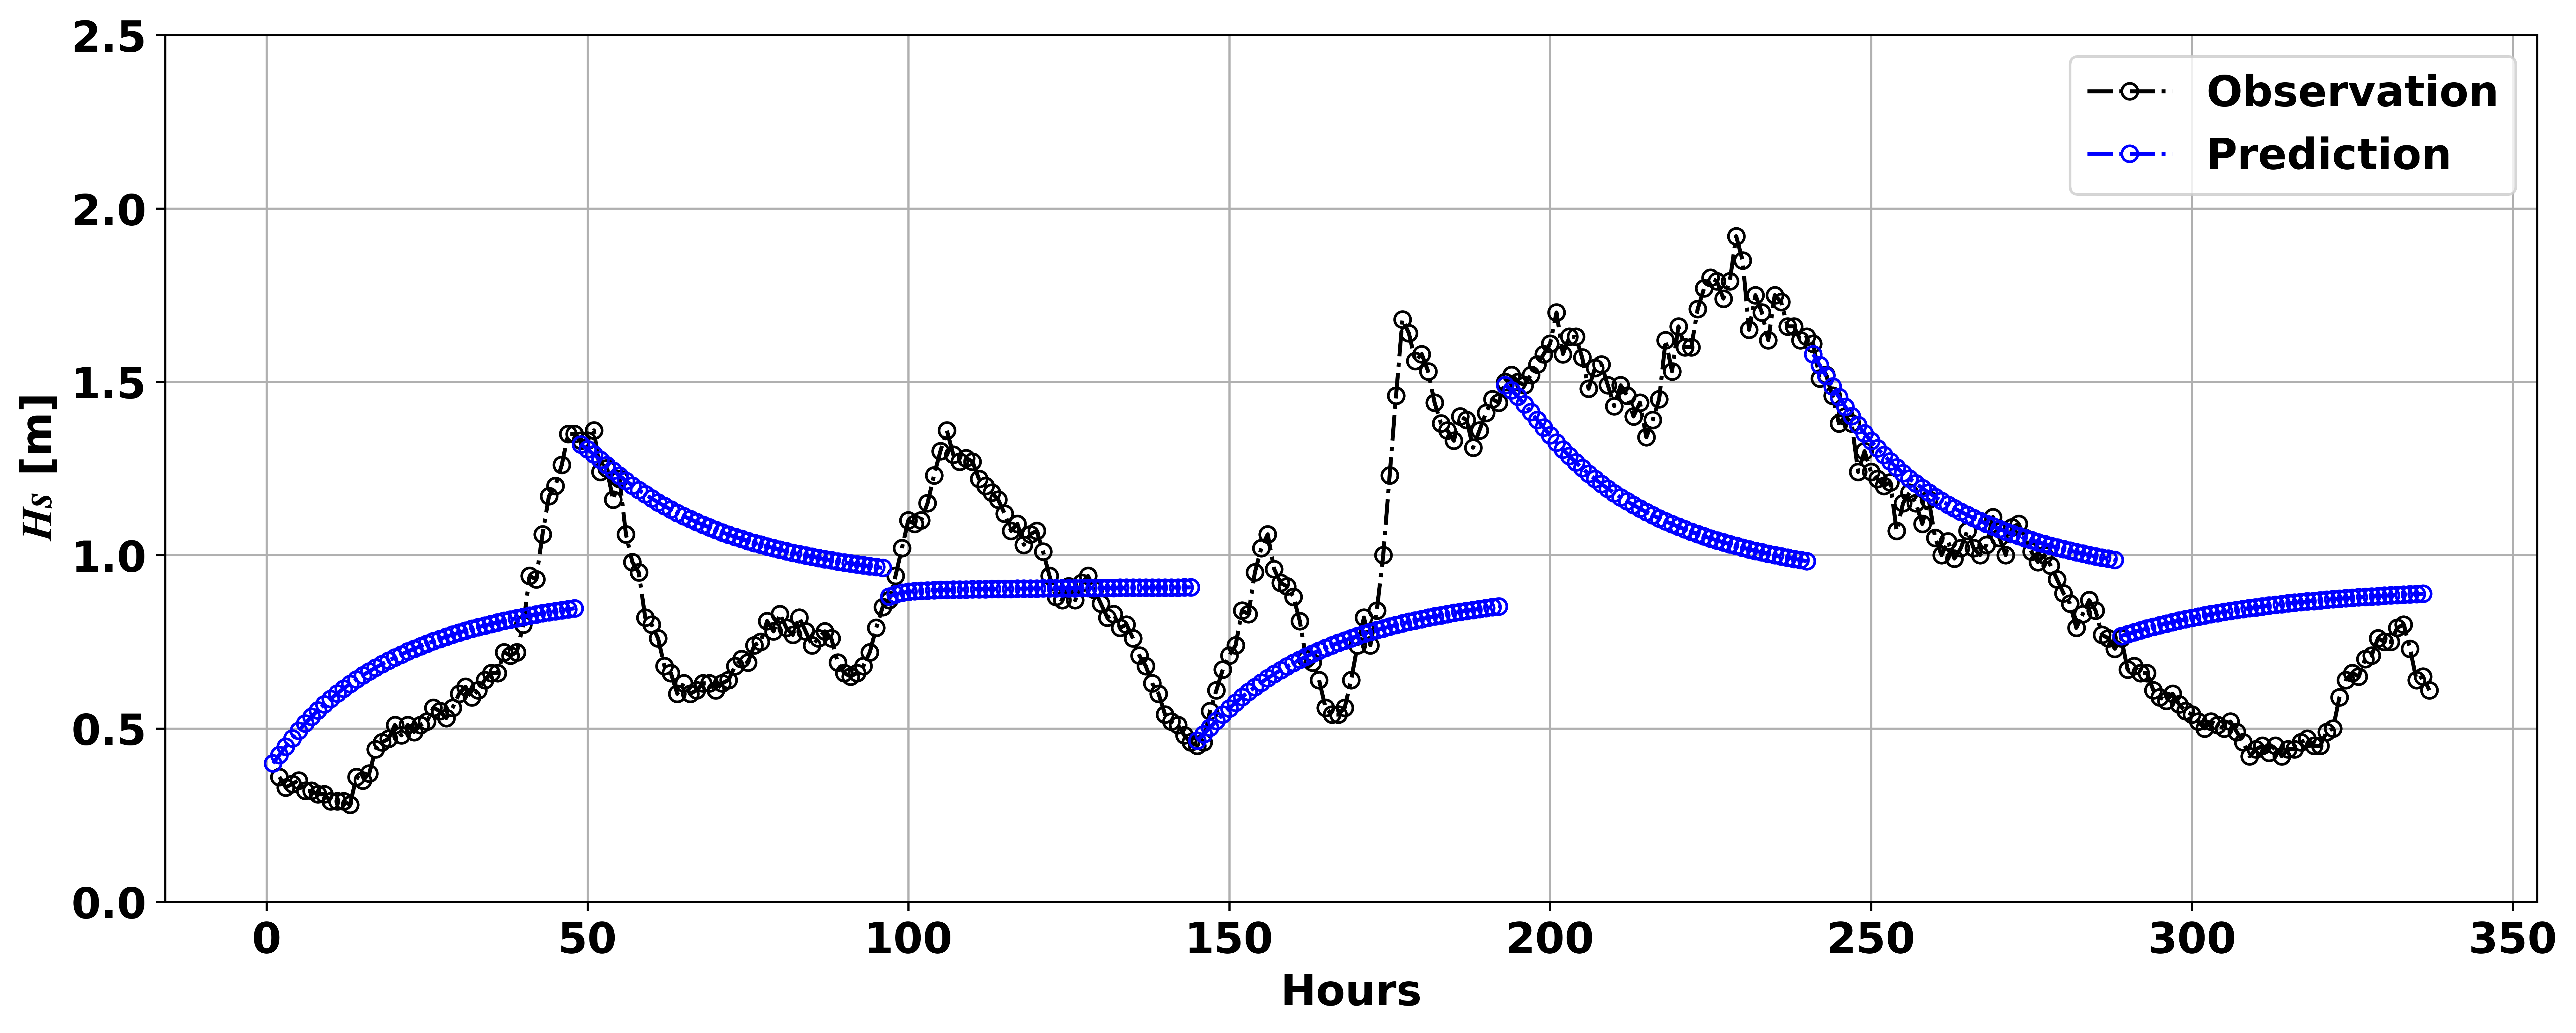

In [55]:
fig, ax = plt.subplots(figsize=(16,6), dpi=600)

n0=0
n1=48  # disesuaikan dgn jumlah yg akan diprediksi
for i in range(0, pred_data_all.shape[0]):  # 12 jam: 28, 24 jam: 14, 48 jam: 7
  if i == 0:
    labels = True
  else:
    labels = False

  plot_predict_all12(pred_data_all_inv[n0:n1], testY_inv, fig, ax, n0, n1, labels=labels)
  n0 += 48  # disesuaikan dgn jumlah yg akan diprediksi
  n1 += 48  # disesuaikan dgn jumlah yg akan diprediksi

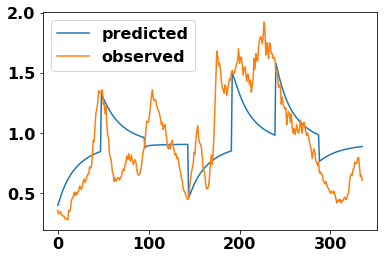

In [57]:
# Concat and save to csv
pred_df = pd.DataFrame(pred_data_all_inv)

all_df = pd.concat([pred_df, pd.DataFrame(testY_inv[1760:2096].flatten())], axis=1, ignore_index=True)
all_df.columns = ['predicted', 'observed']
#all_df.to_csv('gdrive/My Drive/Hasil Model/GL_multistep_48jam.csv')
all_df.plot()